# Alchool Expenditure Classification

# Imports

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score, RepeatedKFold, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.dummy import DummyRegressor

# Functions

In [85]:
def check_nulls_dupes(df):
  print(f"Total Amount Null Values: {df.isna().sum()}")
  print(f"Total Amount of Duplicated Values: {df.duplicated().sum()}")

def get_regression_models(names):
  models= {
    "LR":LinearRegression(),
    "RFC":RandomForestRegressor(),
    "GBC":GradientBoostingRegressor(),
    "DTC": DecisionTreeRegressor(),
    "XGB":XGBRegressor(),
    "Lasso":Lasso(),
    "Ridge":Ridge()
  }
  return [models[model_name] for model_name in names]

def evaluate_regression_model(X,y, model, metric):
  
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def plot_tested_models(df, y):
  
  fig, ax = plt.subplots(figsize=(10, 6))
  df.plot.bar(x="Model",y=y, ax=ax)
  ax.set_xlabel("Model")
  ax.set_ylabel("Accuracy")
  ax.set_title("Model Performance Comparison")
  
  ax.legend(y)
  ax.grid(True)
  plt.xticks(rotation=45)
  plt.show()

def testing_selected_models(names, models, X, y, metric):
  
  model_performance = []
  
  for i in range(len(models)):
    model_name, model = names[i], models[i]
    pipeline = Pipeline(steps=[
      ("scaler", StandardScaler()),
      ("power_transformer", PowerTransformer()),
      ("model", model)
    ])
    
    scores = evaluate_regression_model(X, y, pipeline, metric)
    model_performance.append({
      "Model": model_name,
      "Mean": np.mean(scores),
      "STD": np.std(scores)
    })
  
  model_performance = pd.DataFrame(model_performance).sort_values(by="Mean", ascending=False)
  print(model_performance)
  plot_tested_models(model_performance, ["Mean", "STD"])

def grid_search(names, models, metrics, param_grid, X, y):
  

  X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
  
  for metric in metrics:
    for i in range(len(models)):
      model_name, model, param = names[i],models[i], param_grid[i]
      grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
      
      grid_search.fit(X_train, y_train)
      best_params = grid_search.best_params_
      best_score = grid_search.best_score_
      best_model = grid_search.best_estimator_
      
      # Validation Training
      y_val_pred = best_model.predict(X_val)
      val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
      val_mae = mean_absolute_error(y_val, y_val_pred)
      val_r2 = r2_score(y_val, y_val_pred)
      
      # Test Training
      best_model = grid_search.best_estimator_
      y_test_pred = best_model.predict(X_test)
      test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
      test_mae = mean_absolute_error(y_test, y_test_pred)
      test_r2 = r2_score(y_test, y_test_pred)
      print(f"Best Parameters: {best_params}")
      print(f"Best Cross-Validation Accuracy: {best_score:.3f}")
      
      
  


# EDA Analysis

In [68]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,country,Code,Year,"Other (at home) (USDA, 2018)","Food stores (at home) (USDA, 2018)","Liquor stores (at home) (USDA, 2018)","All other (away from home) (USDA, 2018)","Hotels & motels (away from home) (USDA, 2018)","Restaurants & bars (away from home) (USDA, 2018)",percentage
0,United States,USA,1935,199000000,65000000,305000000,20000000,81000000,964000000,"12,18%"
1,United States,USA,1936,220000000,95000000,435000000,24000000,97000000,1195000000,"3,98%"
2,United States,USA,1937,235000000,113000000,504000000,28000000,109000000,1299000000,"18,67%"
3,United States,USA,1938,227000000,111000000,479000000,26000000,98000000,1246000000,"1,22%"
4,United States,USA,1939,237000000,122000000,517000000,28000000,103000000,1365000000,"4,96%"
...,...,...,...,...,...,...,...,...,...,...
75,United States,USA,2010,20325518116,20728382105,40244994481,10182515190,4721220000,55153264810,"7,30%"
76,United States,USA,2011,22398210076,21802641216,40828786690,10448883481,4774329000,57935787519,"3,43%"
77,United States,USA,2012,23646140574,22462872896,43336680824,10946909055,4882059000,61508031945,"38,63%"
78,United States,USA,2013,22446796526,22921754302,44994457708,11414860599,4898664000,62861475401,"13,24%"


In [69]:
df.dtypes

country                                             object
Code                                                object
Year                                                 int64
Other (at home) (USDA, 2018)                         int64
Food stores (at home) (USDA, 2018)                   int64
Liquor stores (at home) (USDA, 2018)                 int64
All other (away from home) (USDA, 2018)              int64
Hotels & motels (away from home) (USDA, 2018)        int64
Restaurants & bars (away from home) (USDA, 2018)     int64
percentage                                          object
dtype: object

# Check for Nulls and Dupes

In [70]:
check_nulls_dupes(df)

Total Amount Null Values: country                                             0
Code                                                0
Year                                                0
Other (at home) (USDA, 2018)                        0
Food stores (at home) (USDA, 2018)                  0
Liquor stores (at home) (USDA, 2018)                0
All other (away from home) (USDA, 2018)             0
Hotels & motels (away from home) (USDA, 2018)       0
Restaurants & bars (away from home) (USDA, 2018)    0
percentage                                          0
dtype: int64
Total Amount of Duplicated Values: 0


# Target column is a string, lets fix this

In [71]:
df["percentage"] = df["percentage"].apply(lambda x: float(x[:-1].replace(",",".")))

In [72]:
df.dtypes

country                                              object
Code                                                 object
Year                                                  int64
Other (at home) (USDA, 2018)                          int64
Food stores (at home) (USDA, 2018)                    int64
Liquor stores (at home) (USDA, 2018)                  int64
All other (away from home) (USDA, 2018)               int64
Hotels & motels (away from home) (USDA, 2018)         int64
Restaurants & bars (away from home) (USDA, 2018)      int64
percentage                                          float64
dtype: object

# Lets Remove columns that bring no value to the analysis

In [73]:
df.drop(["country", "Code"], inplace=True, axis=1)

In [74]:
df.describe()

,Year,"Other (at home) (USDA, 2018)","Food stores (at home) (USDA, 2018)","Liquor stores (at home) (USDA, 2018)","All other (away from home) (USDA, 2018)","Hotels & motels (away from home) (USDA, 2018)","Restaurants & bars (away from home) (USDA, 2018)",percentage
count,80.0000,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,80.000000
mean,1974.5000,4.768455e+09,7.138889e+09,1.381007e+10,2.634051e+09,2.067931e+09,1.952678e+10,16.584500
std,23.2379,6.272045e+09,7.424327e+09,1.267895e+10,3.392675e+09,1.914253e+09,1.913043e+10,15.669026
min,1935.0000,1.990000e+08,6.500000e+07,3.050000e+08,2.000000e+07,8.100000e+07,9.640000e+08,1.200000
25%,1954.7500,5.785000e+08,7.122500e+08,3.030500e+09,2.240000e+08,2.880000e+08,4.534500e+09,4.825000
50%,1974.5000,1.437000e+09,3.840000e+09,1.031450e+10,8.325000e+08,1.241000e+09,9.847500e+09,8.440000
75%,1994.2500,6.834536e+09,1.187085e+10,1.891784e+10,4.045904e+09,3.270838e+09,2.946909e+10,28.310000
max,2014.0000,2.364614e+10,2.352304e+10,4.752358e+10,1.148294e+10,7.042605e+09,6.686040e+10,59.000000


# Visuals

<AxesSubplot:>

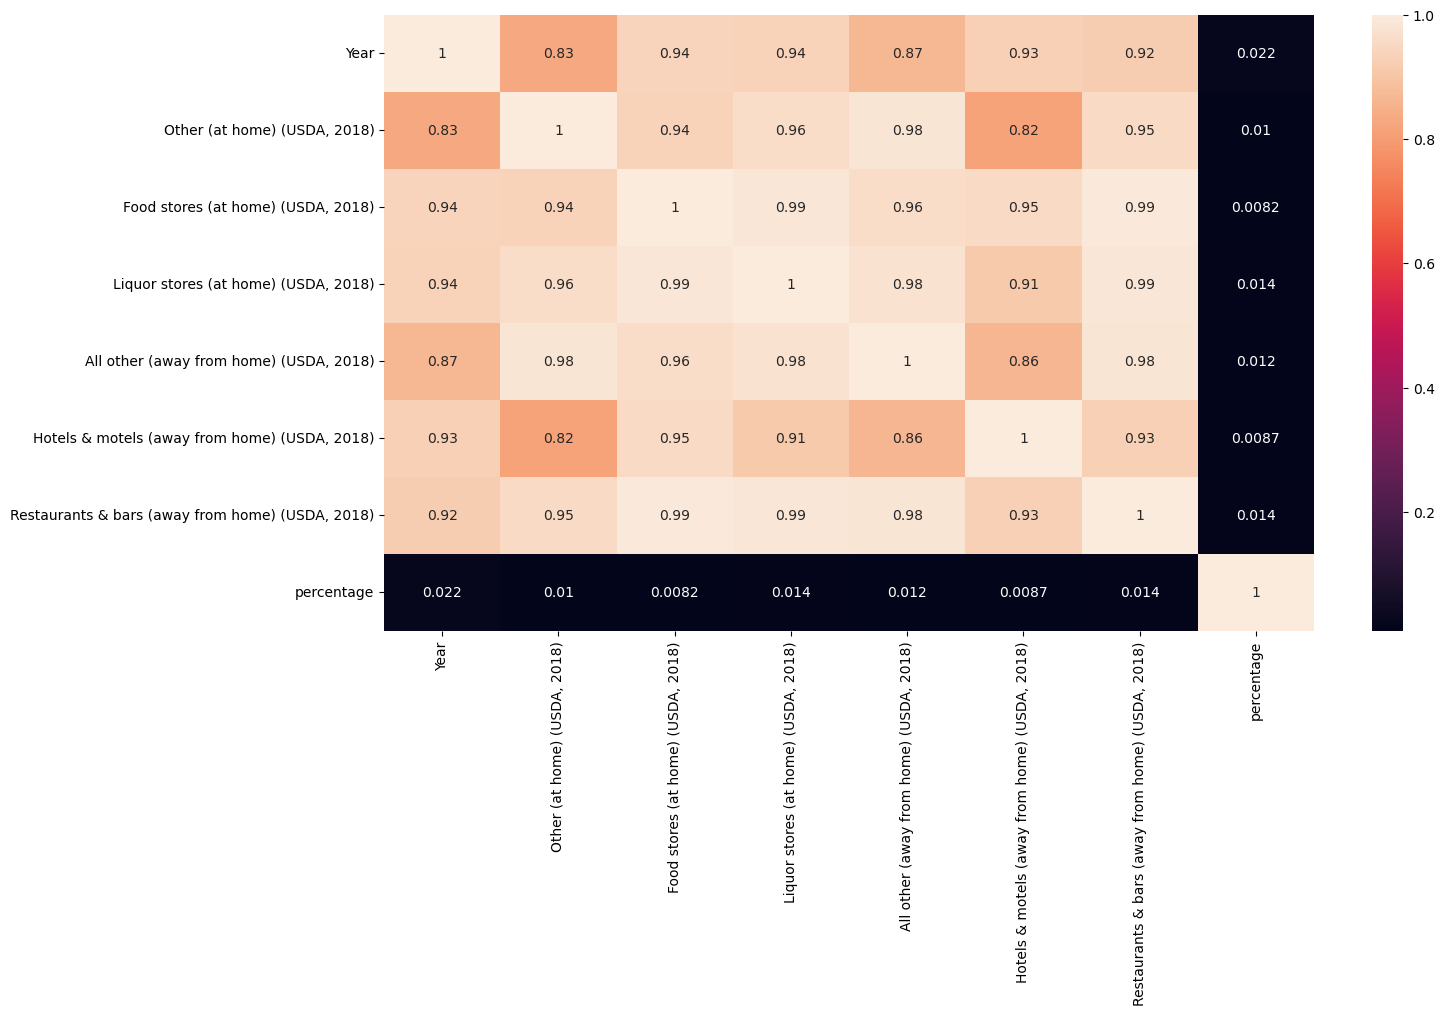

In [75]:
plt.figure(figsize=(15, 8))
sns.heatmap(data=df.corr(), annot=True)

<AxesSubplot:xlabel='Year', ylabel='percentage'>

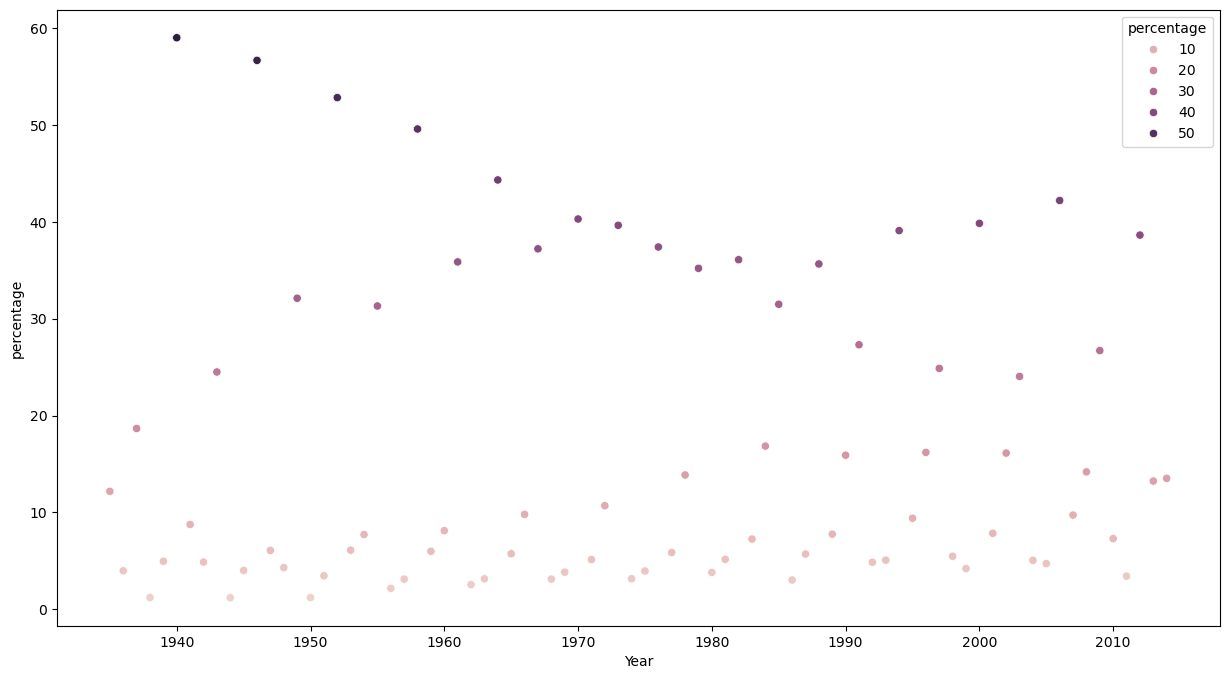

In [76]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x="Year", y="percentage", hue="percentage" )

<AxesSubplot:xlabel='Year', ylabel='Restaurants & bars (away from home) (USDA, 2018)'>

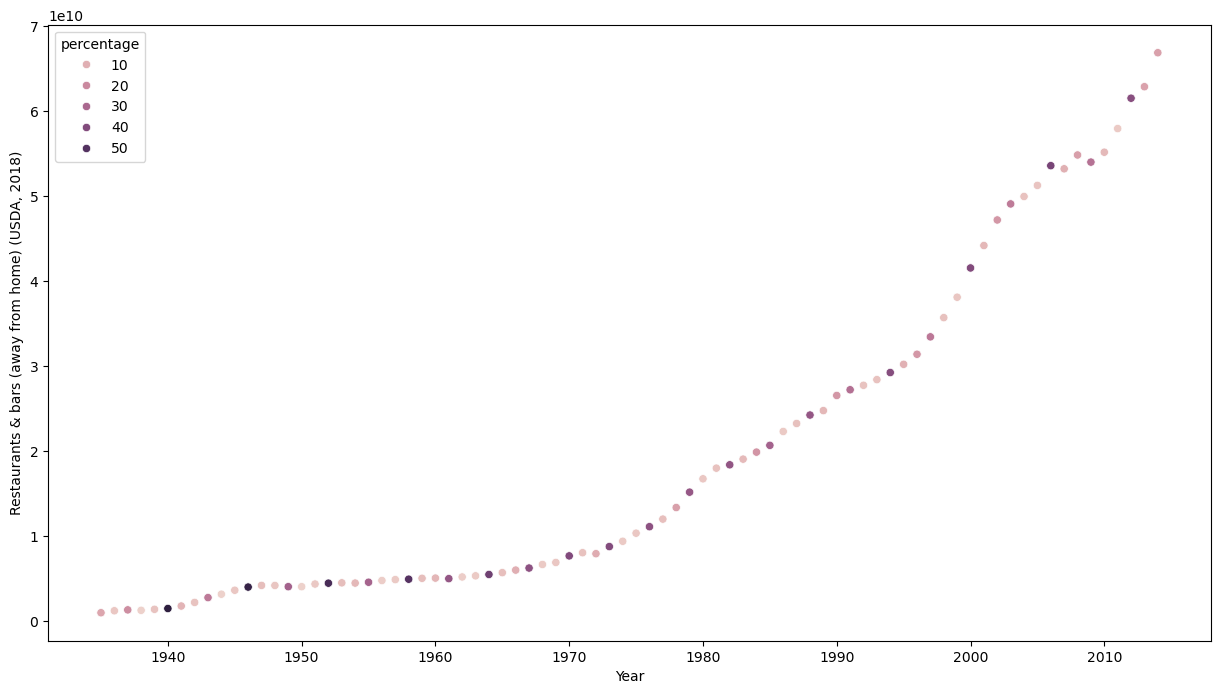

In [77]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x="Year", y="Restaurants & bars (away from home) (USDA, 2018)",  hue="percentage")

# There seems to be a relationship between the percentage on alchool spent on money at dining events

<AxesSubplot:xlabel='Year', ylabel='Liquor stores (at home) (USDA, 2018)'>

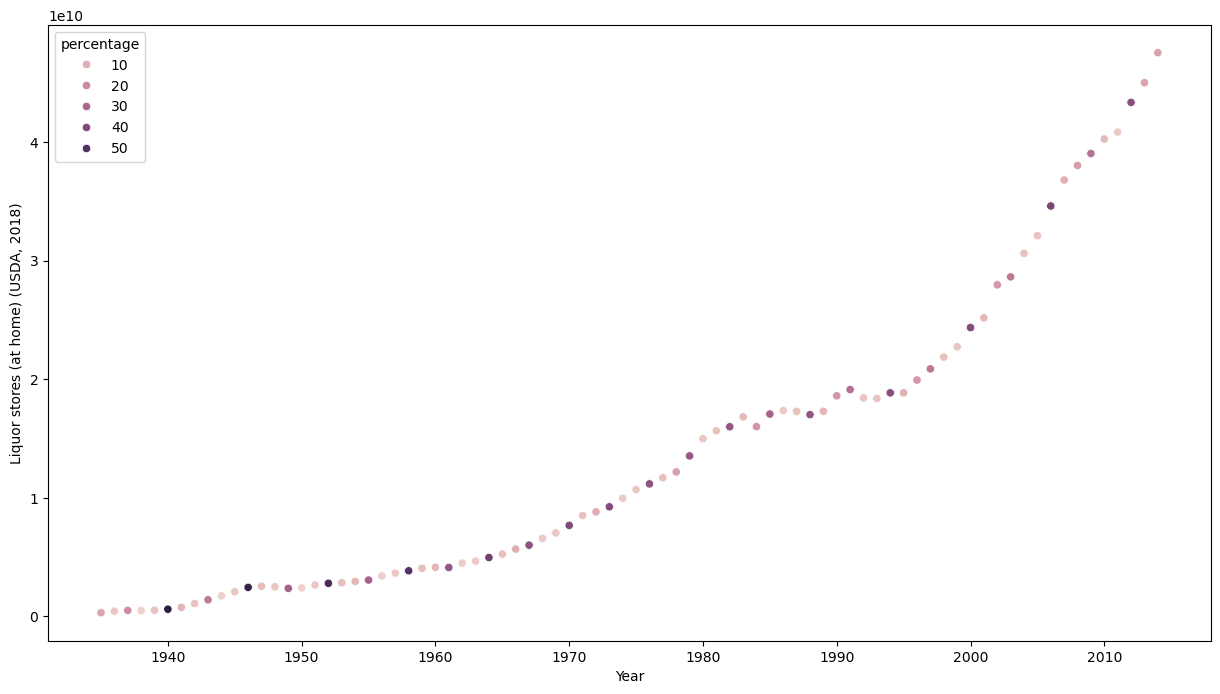

In [78]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x="Year", y="Liquor stores (at home) (USDA, 2018)",  hue="percentage")

<AxesSubplot:xlabel='Year', ylabel='All other (away from home) (USDA, 2018)'>

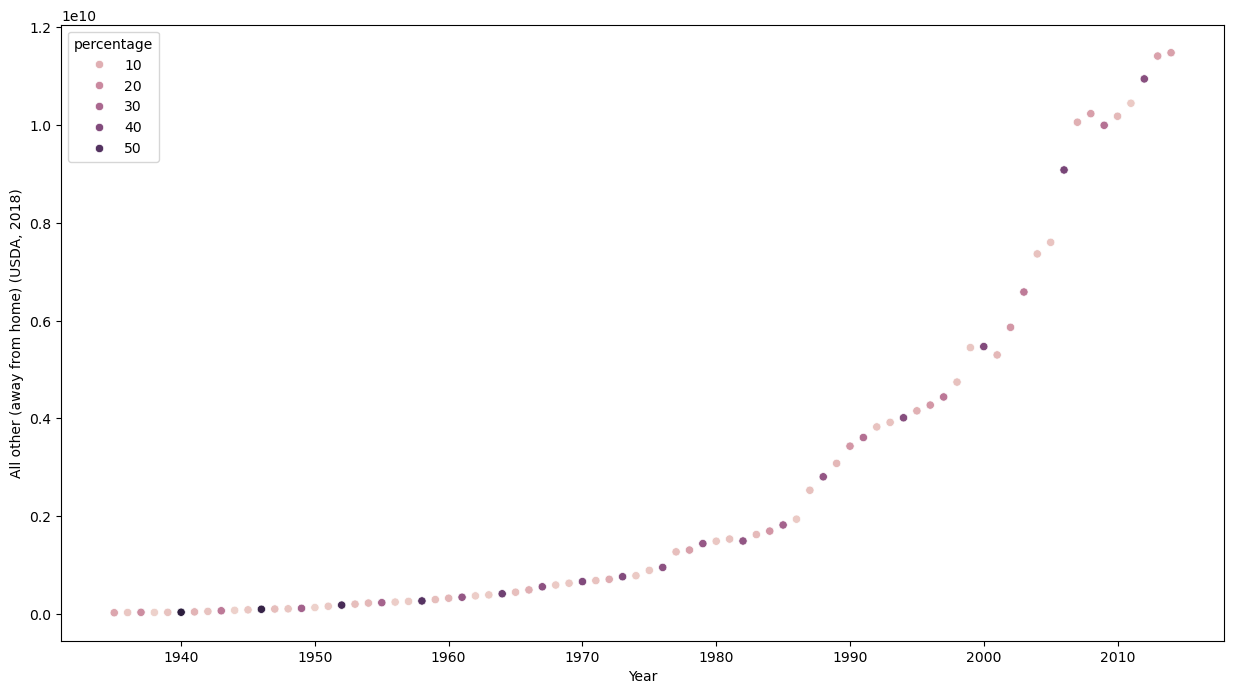

In [79]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x="Year", y="All other (away from home) (USDA, 2018)",  hue="percentage")

# We're seeing this relationship for multiple columns this could be due to a number of factors like poor reporting in earlier, years, stagnant wages, costs of inflation in products taking up a larger and larger portion of the amount of available money to spend. We cannot assume this mean that alcholism is on the rise but we also cannot rule this out.

# Separate Features

In [80]:
X, y = df.drop("percentage", axis=1), df["percentage"]

# Baseline Model

In [82]:
model = DummyRegressor(strategy="mean")
metric = make_scorer(mean_squared_error)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = evaluate_regression_model(X, y, model, metric)
print('Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean: 249.677 (97.508)


# Advanced Model Metrics

# Mean squared error

  Model        Mean         STD
3   DTC  686.316869  233.633657
2   XGB  661.874216  235.655901
1   GBC  473.476084  181.981938
4   RFC  461.649603  163.296479
0    LR  304.014788  121.719859


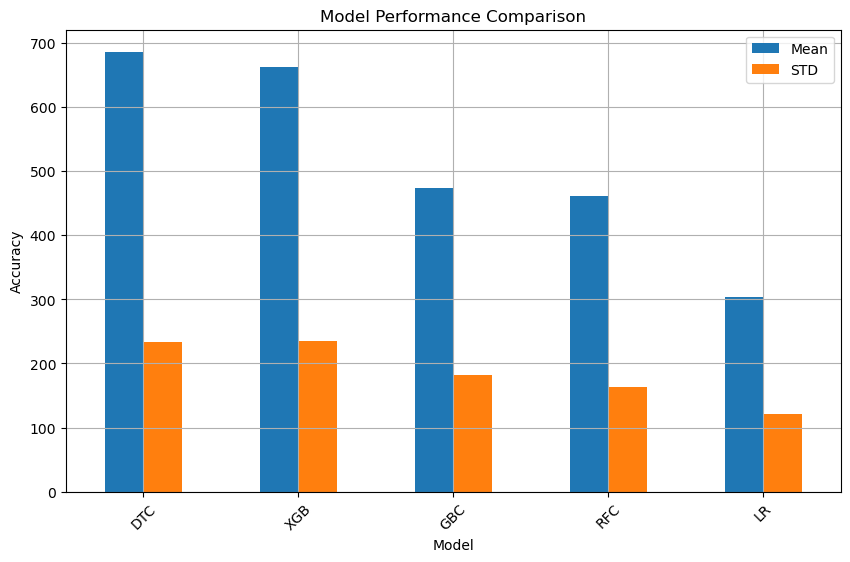

In [86]:
names = ["LR", "GBC", "XGB","DTC", "RFC"]
models = get_regression_models(names)
metric = make_scorer(mean_squared_error)
testing_selected_models(names, models, X, y, metric)

# Mean Absolute Error as the metric

  Model       Mean       STD
2   XGB  20.970498  5.053198
3   DTC  20.897000  4.919491
4   RFC  18.317688  3.627585
1   GBC  18.130826  3.915414
0    LR  14.835997  2.830138


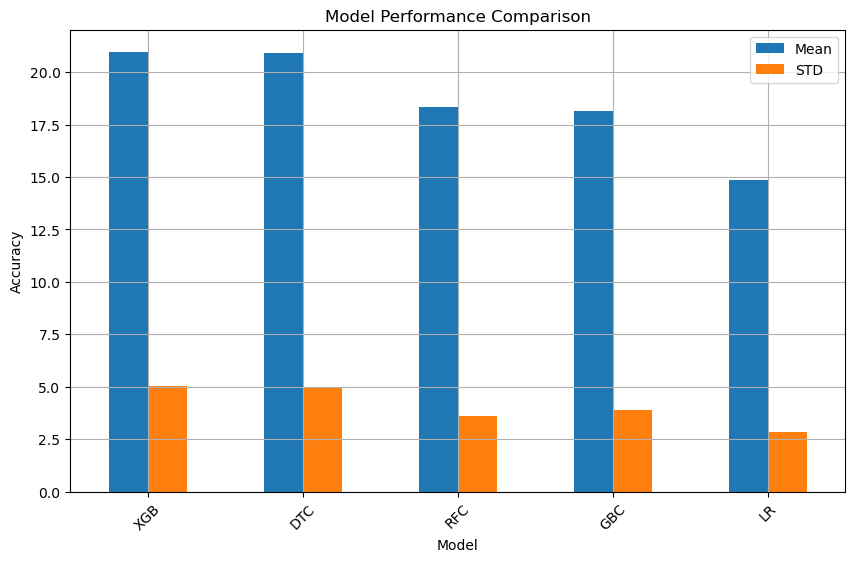

In [87]:
names = ["LR", "GBC", "XGB","DTC", "RFC"]
models = get_regression_models(names)
metric = make_scorer(mean_absolute_error)
testing_selected_models(names, models, X, y, metric)

# RMSE

  Model       Mean       STD
3   DTC  25.576326  4.431485
2   XGB  25.258891  4.884942
1   GBC  21.455138  4.232322
4   RFC  21.087783  3.892619
0    LR  17.111587  3.347889


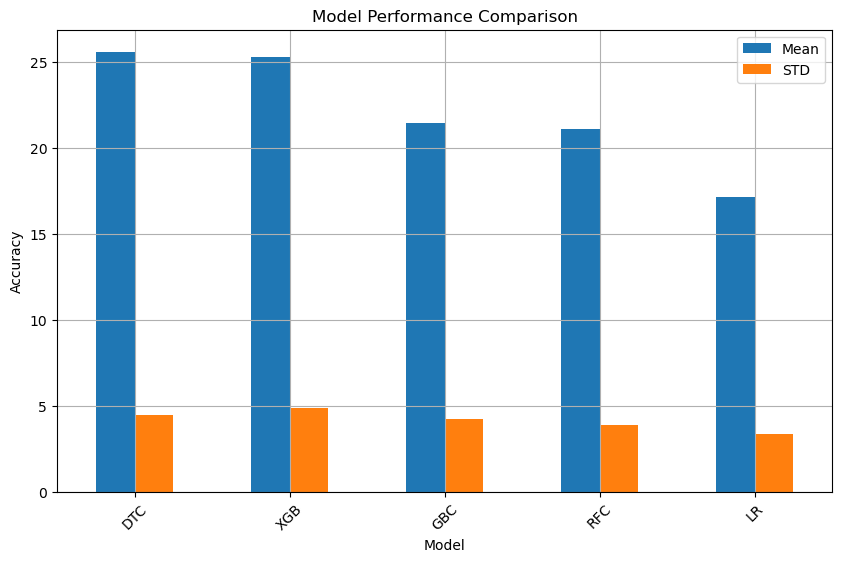

In [90]:
names = ["LR", "GBC", "XGB","DTC", "RFC"]
models = get_regression_models(names)
metric = make_scorer(mean_squared_error, squared=False)
testing_selected_models(names, models, X, y, metric)

# Hyper parameter tuning

In [ ]:
param_grid = {
  "GBC":{
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
  },
  
  "RFC":{
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
  },
  
  "Ridge":{
    'alpha': [0.1, 1.0, 10.0, 100.0]
  },
  "Lasso":{
    'alpha': [0.1, 1.0, 10.0, 100.0]
  }
  
}